Mounted at /content/drive
Dataset shape: (189381, 25)
Dataset shape after cleaning timestamps: (189381, 25)
Missing values:
cpu_usage                   0
top_1_cpu_proc_usage        0
top_2_cpu_proc_usage        0
top_3_cpu_proc_usage        0
top_4_cpu_proc_usage        0
top_5_cpu_proc_usage        0
mem_usage                   0
top_1_mem_proc_usage        0
top_2_mem_proc_usage        0
top_3_mem_proc_usage        0
top_4_mem_proc_usage        0
top_5_mem_proc_usage        0
nginx_active_connections    0
nginx_rps                   0
hour                        0
day_of_week                 0
day_of_month                0
dtype: int64


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 17)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 17)                  │           1,105 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,521 (29.38 KB)

 Trainable params: 7,521 (29.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.0186 - val_loss: 0.0015
Epoch 2/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 0.0045 - val_loss: 0.0012
Epoch 3/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.0037 - val_loss: 0.0011
Epoch 4/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 5/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 6/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 7/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 8/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0028 - val_loss: 0.0010
Epoch 9/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 10/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 11/50
4735/4735 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 12/50
4735/47

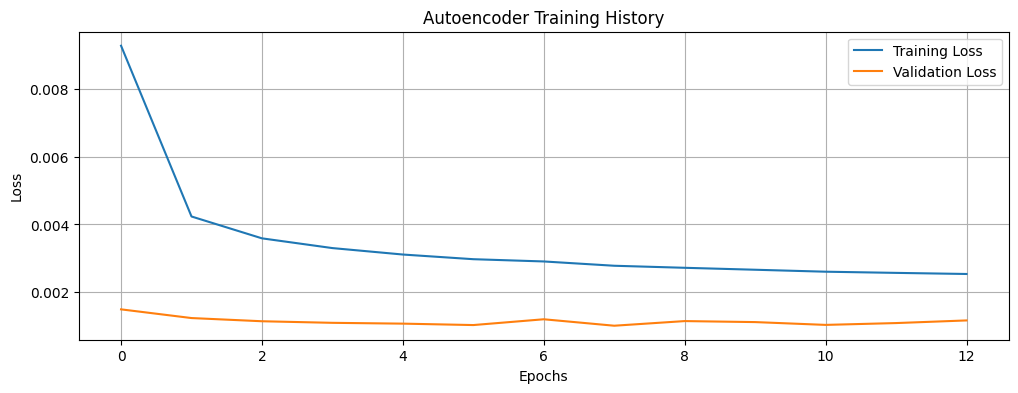

5919/5919 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step

===== Autoencoder Evaluation Metrics =====
MAE: 0.016558
MSE: 0.001001
RMSE: 0.031634

===== Feature-wise Reconstruction Errors =====
                     Feature       MAE       MSE      RMSE
1       top_1_cpu_proc_usage  0.041505  0.002888  0.053740
14                      hour  0.041555  0.002413  0.049124
0                  cpu_usage  0.015733  0.001869  0.043231
2       top_2_cpu_proc_usage  0.018238  0.001596  0.039956
12  nginx_active_connections  0.020343  0.001161  0.034079
15               day_of_week  0.024434  0.001158  0.034025
16              day_of_month  0.023461  0.001050  0.032404
6                  mem_usage  0.019267  0.001044  0.032307
8       top_2_mem_proc_usage  0.023563  0.000992  0.031502
7       top_1_mem_proc_usage  0.012205  0.000681  0.026087
11      top_5_mem_proc_usage  0.014787  0.000554  0.023534
3       top_3_cpu_proc_usage  0.006915  0.000509  0.022569
10      top_4_mem_proc_usage  0.006412  0.000395  0.019

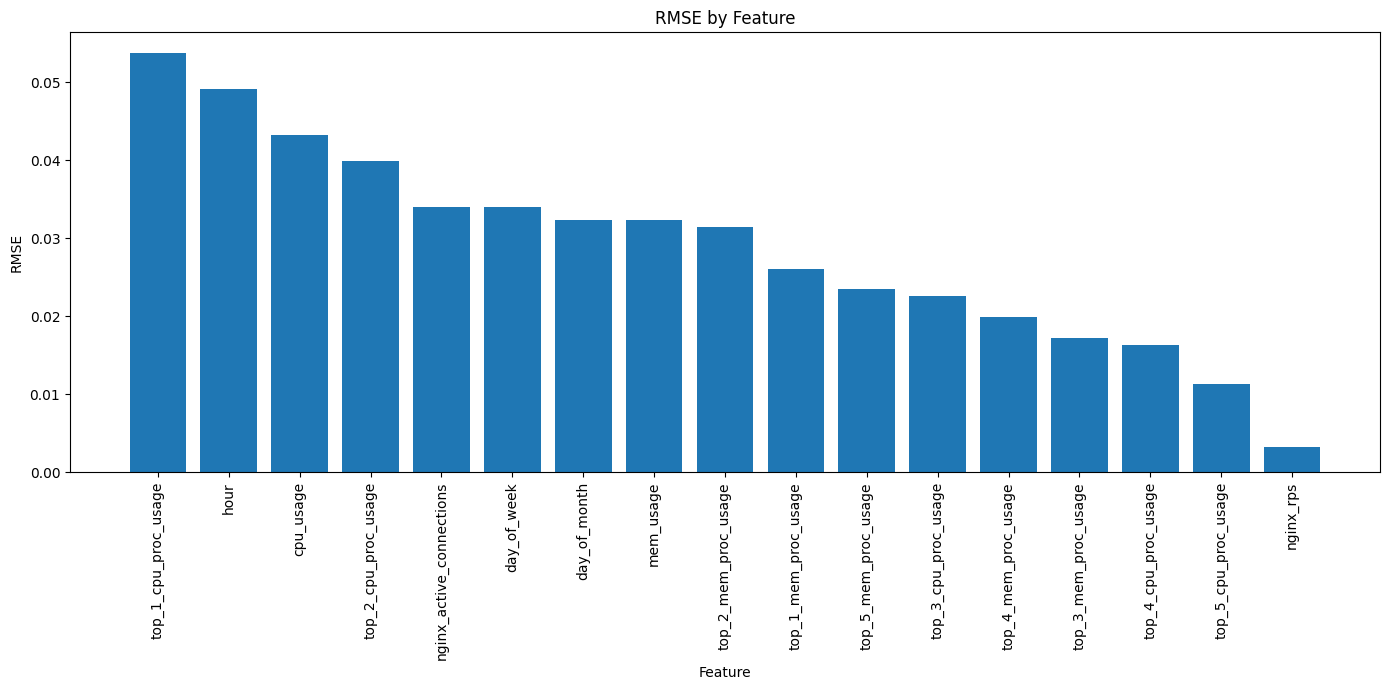

Anomaly threshold: 0.004584932668745524
Number of anomalies detected: 4073 (2.15%)


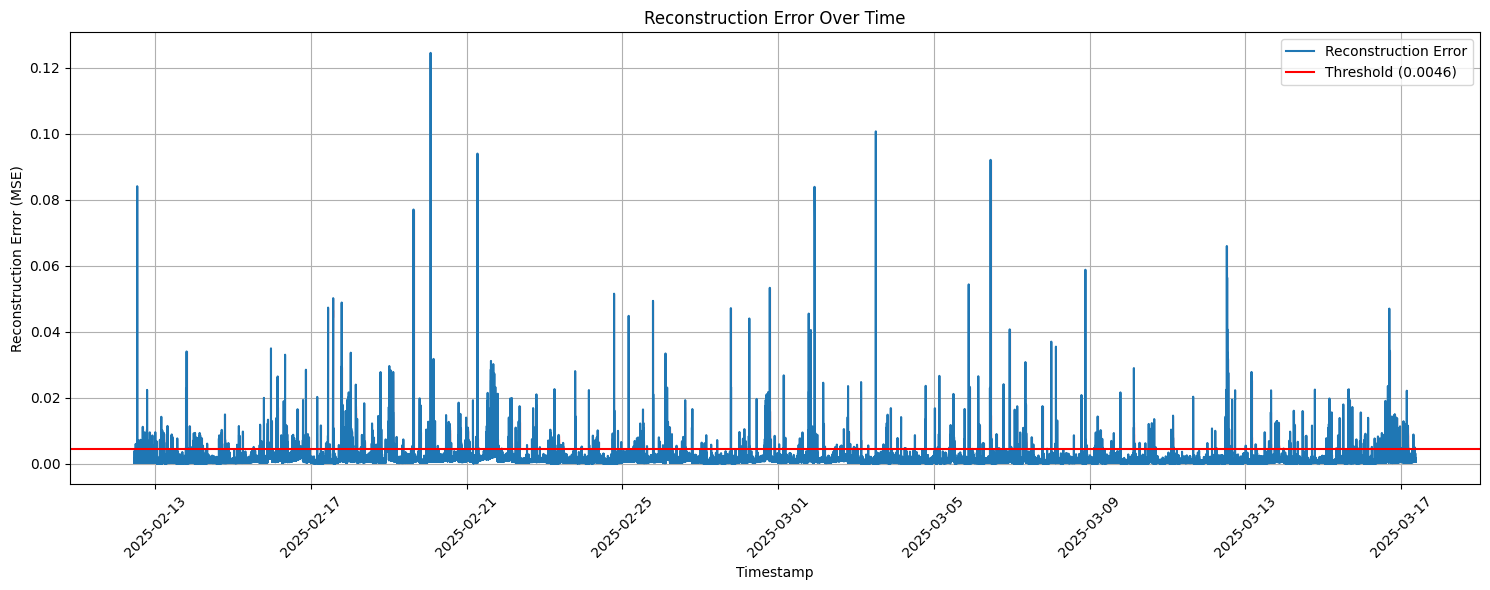

Top 10 anomalies by reconstruction error:


,timestamp,cpu_usage,mem_usage,nginx_rps,reconstruction_error
43754,2025-02-20 01:43:55,100.0,85.8,27.14,0.124565
109543,2025-03-03 12:13:20,100.0,56.4,7.91,0.100770
50684,2025-02-21 06:38:17,100.0,85.1,13.17,0.094038
109535,2025-03-03 12:11:20,88.6,55.1,7.84,0.092302
126493,2025-03-06 10:59:19,100.0,62.7,11.49,0.092147
43753,2025-02-20 01:43:30,100.0,60.0,19.26,0.088349
458,2025-02-12 12:51:32,50.6,55.9,0.66,0.084152
100506,2025-03-01 22:26:20,100.0,89.7,0.00,0.083966
100507,2025-03-01 22:33:31,22.5,25.5,6597.93,0.077291
41227,2025-02-19 15:11:59,100.0,55.7,3.33,0.077092


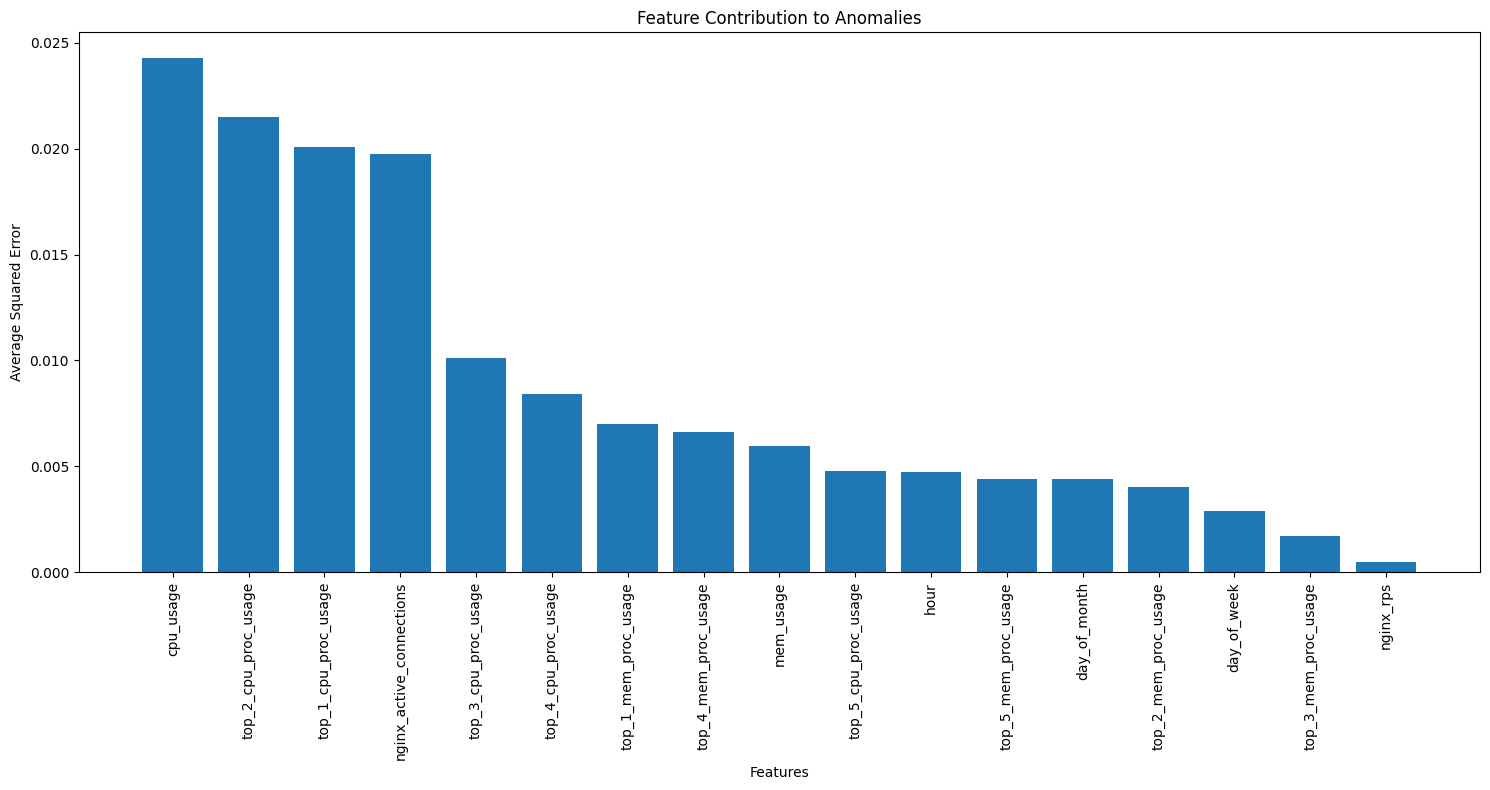

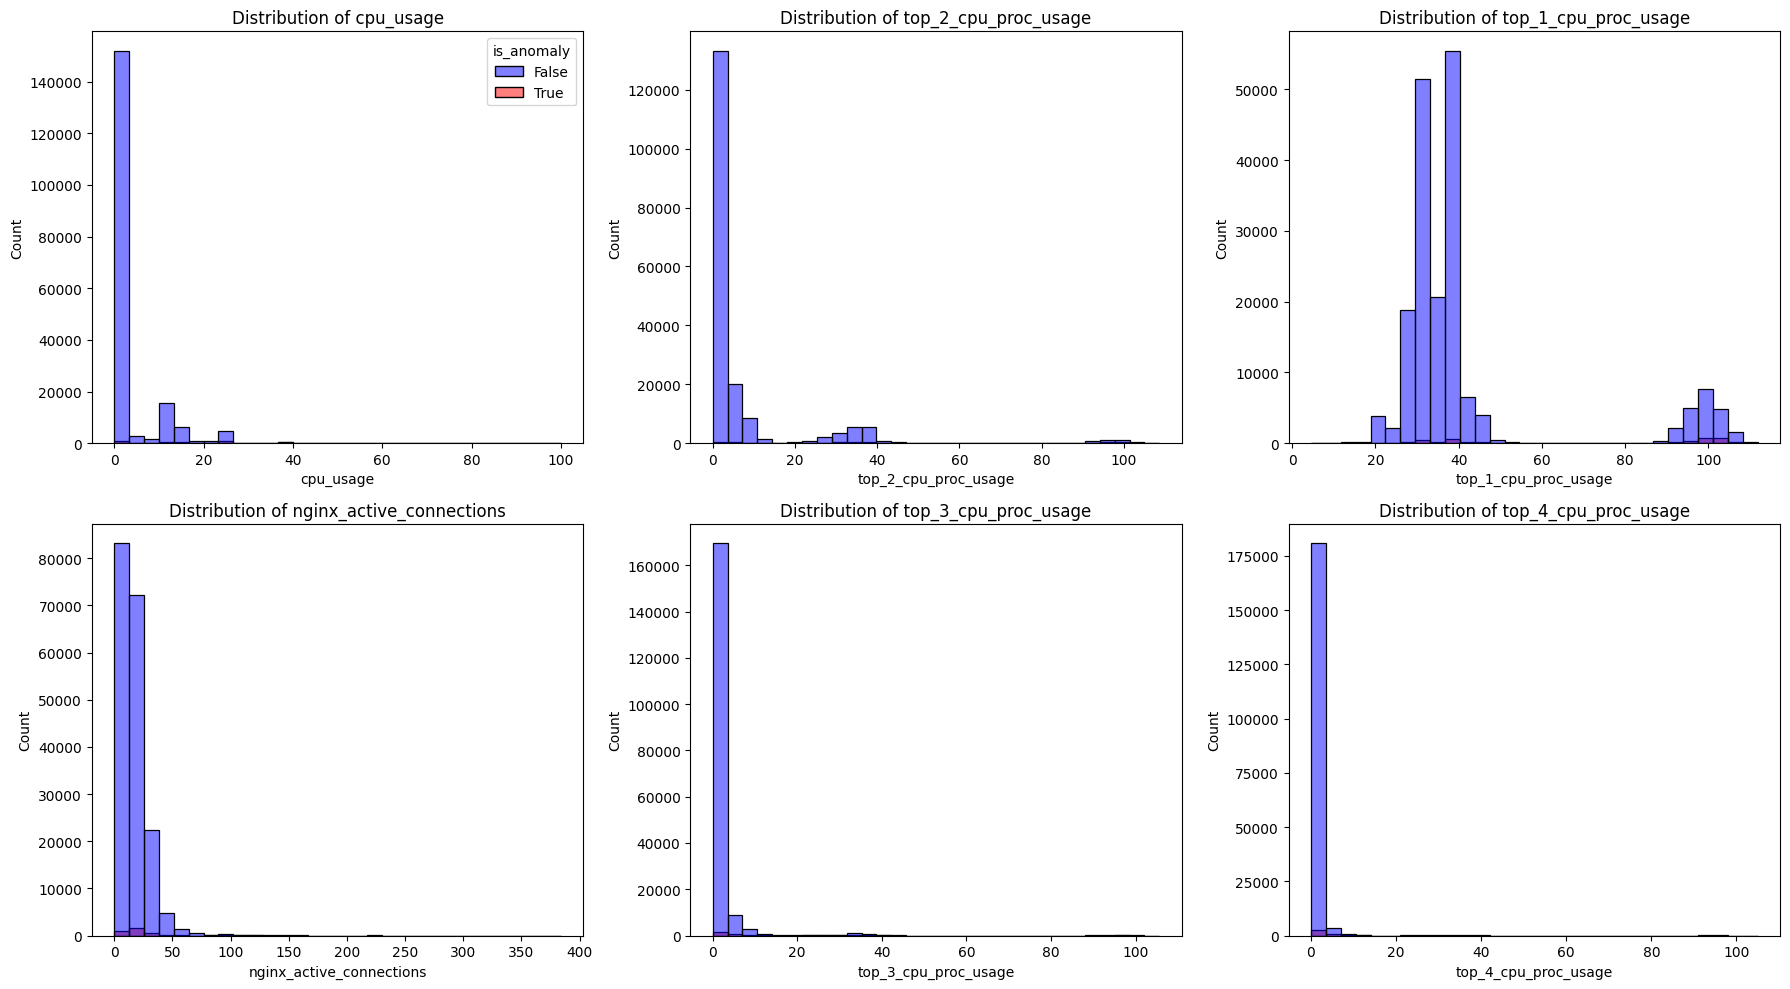

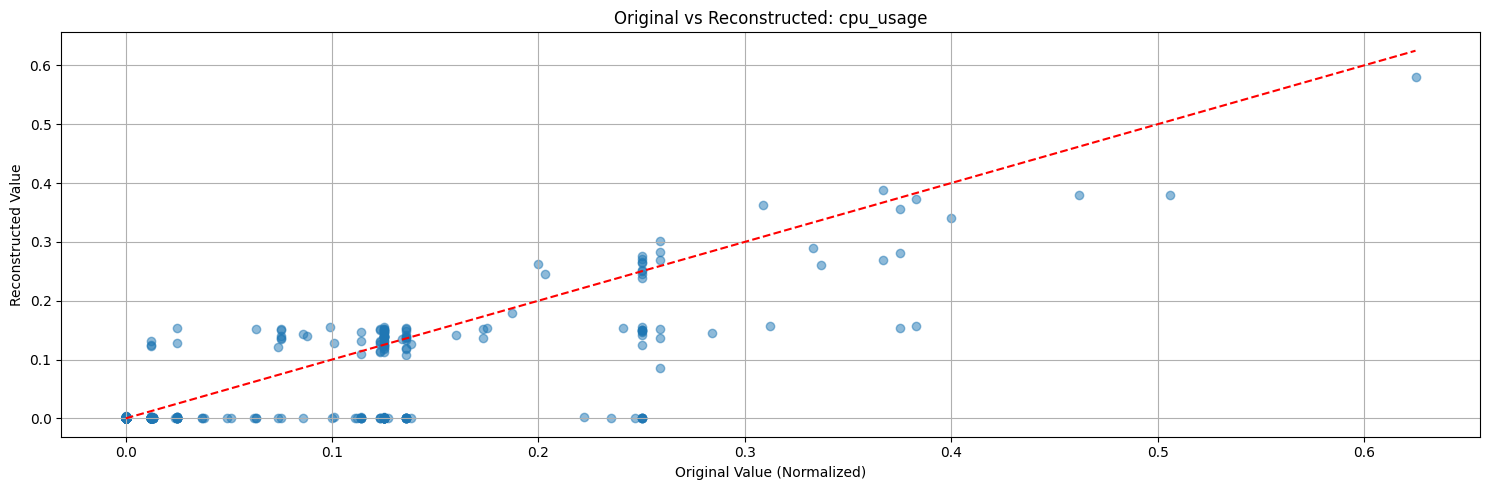

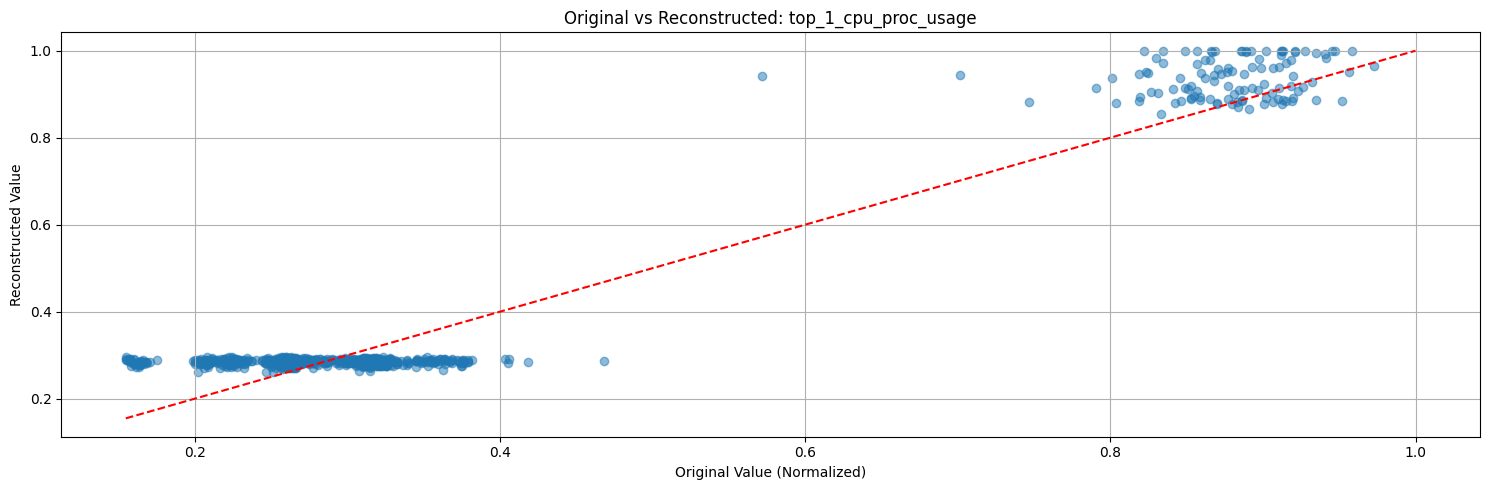

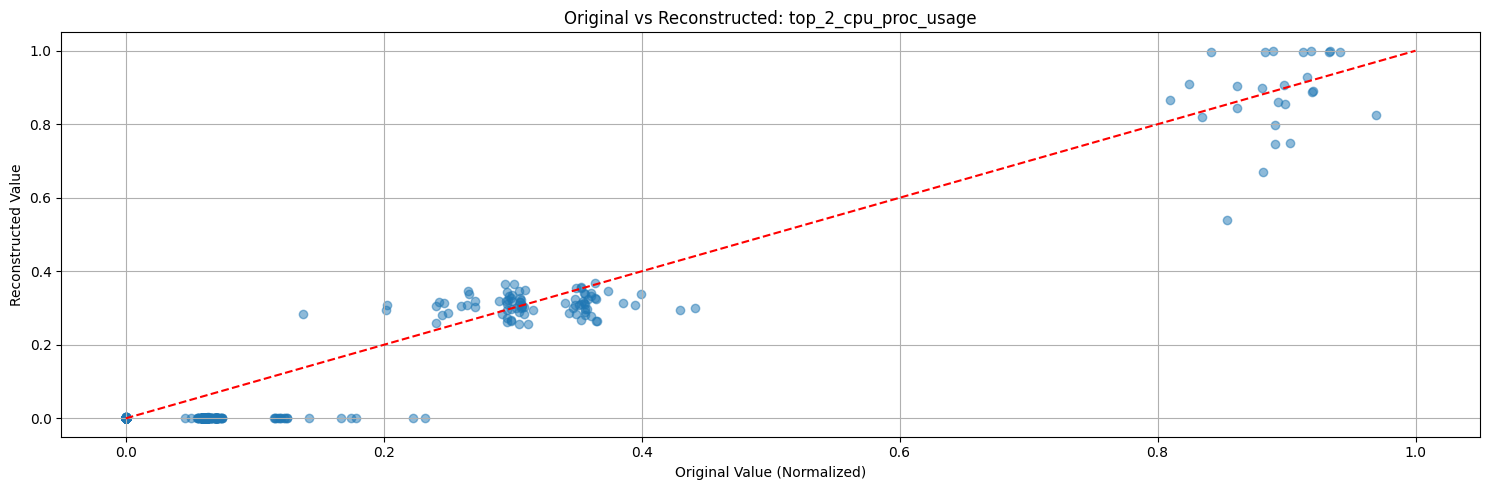

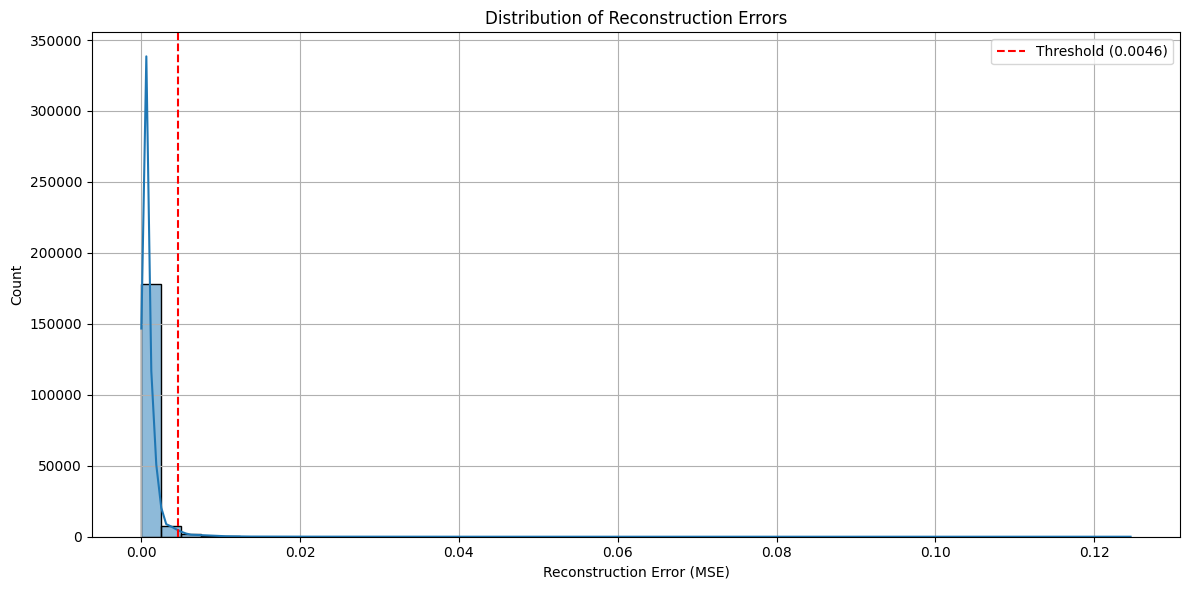

Model saved to Google Drive
Full results with original features and anomaly flags saved to Google Drive
Saved 4073 anomalies to a separate file
Evaluation metrics saved to Google Drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
import datetime
import math

# Mount Google Drive
drive.mount('/content/drive')

# Define headers for the dataset
header = [
    "timestamp",
    "cpu_usage",
    "top_1_cpu_proc_name",
    "top_1_cpu_proc_usage",
    "top_2_cpu_proc_name",
    "top_2_cpu_proc_usage",
    "top_3_cpu_proc_name",
    "top_3_cpu_proc_usage",
    "top_4_cpu_proc_name",
    "top_4_cpu_proc_usage",
    "top_5_cpu_proc_name",
    "top_5_cpu_proc_usage",
    "mem_usage",
    "top_1_mem_proc_name",
    "top_1_mem_proc_usage",
    "top_2_mem_proc_name",
    "top_2_mem_proc_usage",
    "top_3_mem_proc_name",
    "top_3_mem_proc_usage",
    "top_4_mem_proc_name",
    "top_4_mem_proc_usage",
    "top_5_mem_proc_name",
    "top_5_mem_proc_usage",
    "nginx_active_connections",
    "nginx_rps"
]

# Load the dataset with semicolon delimiter
df = pd.read_csv(
    "drive/MyDrive/Colab Notebooks/dataset/system_stats.csv",
    header=None,
    names=header,
    sep=';',
    low_memory=False,
    on_bad_lines='skip'
)

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

# Handle timestamp parsing
# First, clean up any extra characters that might interfere with parsing
df['timestamp'] = df['timestamp'].str.replace('T', ' ')
df['timestamp'] = df['timestamp'].str.split('.').str[0]

# Now try to parse timestamps
try:
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
except:
    print("Warning: Some timestamp parsing failed, using a more flexible approach")
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Drop rows with invalid timestamps
df = df.dropna(subset=['timestamp'])
print(f"Dataset shape after cleaning timestamps: {df.shape}")

# Extract time features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_of_month'] = df['timestamp'].dt.day

# Check data types and convert numerical columns from strings to float
numeric_cols = [
    'cpu_usage', 'top_1_cpu_proc_usage', 'top_2_cpu_proc_usage',
    'top_3_cpu_proc_usage', 'top_4_cpu_proc_usage', 'top_5_cpu_proc_usage',
    'mem_usage', 'top_1_mem_proc_usage', 'top_2_mem_proc_usage',
    'top_3_mem_proc_usage', 'top_4_mem_proc_usage', 'top_5_mem_proc_usage',
    'nginx_active_connections', 'nginx_rps'
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Select only numerical features for the autoencoder (excluding process names)
numerical_features = [
    'cpu_usage', 'top_1_cpu_proc_usage', 'top_2_cpu_proc_usage',
    'top_3_cpu_proc_usage', 'top_4_cpu_proc_usage', 'top_5_cpu_proc_usage',
    'mem_usage', 'top_1_mem_proc_usage', 'top_2_mem_proc_usage',
    'top_3_mem_proc_usage', 'top_4_mem_proc_usage', 'top_5_mem_proc_usage',
    'nginx_active_connections', 'nginx_rps',
    'hour', 'day_of_week', 'day_of_month'
]

# These are the features we'll use for training
features = numerical_features.copy()

# Check for and handle missing values
print(f"Missing values:\n{df[features].isna().sum()}")
df[features] = df[features].fillna(0)

# Normalize the data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

# Split the data
X_train, X_test = train_test_split(df_scaled, test_size=0.2, random_state=42)

# Build the autoencoder model
input_dim = X_train.shape[1]

# Define the encoder
input_layer = Input(shape=(input_dim,))
# Encoder layers
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dropout(0.2)(encoder)
encoder = Dense(32, activation='relu')(encoder)
encoder = Dropout(0.2)(encoder)

# Bottleneck layer
bottleneck = Dense(16, activation='relu')(encoder)

# Decoder layers
decoder = Dense(32, activation='relu')(bottleneck)
decoder = Dropout(0.2)(decoder)
decoder = Dense(64, activation='relu')(decoder)
decoder = Dropout(0.2)(decoder)

# Output layer
output_layer = Dense(input_dim, activation='sigmoid')(decoder)

# Create model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Print model summary
autoencoder.summary()

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Get reconstruction on the entire dataset
reconstructed = autoencoder.predict(df_scaled)

# Calculate evaluation metrics
# MAE (Mean Absolute Error)
mae = mean_absolute_error(df_scaled, reconstructed)
# MSE (Mean Squared Error)
mse = mean_squared_error(df_scaled, reconstructed)
# RMSE (Root Mean Squared Error)
rmse = math.sqrt(mse)

print("\n===== Autoencoder Evaluation Metrics =====")
print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")

# Calculate per-feature reconstruction errors for analysis
feature_mae = np.mean(np.abs(df_scaled.values - reconstructed), axis=0)
feature_mse = np.mean(np.square(df_scaled.values - reconstructed), axis=0)
feature_rmse = np.sqrt(feature_mse)

# Create dataframe for feature-wise metrics
feature_metrics = pd.DataFrame({
    'Feature': features,
    'MAE': feature_mae,
    'MSE': feature_mse,
    'RMSE': feature_rmse
})

# Sort by RMSE to see which features have the highest reconstruction error
feature_metrics_sorted = feature_metrics.sort_values('RMSE', ascending=False)
print("\n===== Feature-wise Reconstruction Errors =====")
print(feature_metrics_sorted)

# Visualize feature-wise reconstruction errors
plt.figure(figsize=(14, 7))
plt.bar(feature_metrics_sorted['Feature'], feature_metrics_sorted['RMSE'])
plt.title('RMSE by Feature')
plt.xlabel('Feature')
plt.ylabel('RMSE')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Get reconstruction error on the entire dataset (per-sample MSE)
sample_mse = np.mean(np.power(df_scaled - reconstructed, 2), axis=1)

# Add reconstruction error to original dataframe
df['reconstruction_error'] = sample_mse

# Determine anomaly threshold (you can adjust this based on your needs)
# Here we use mean + 2*std as threshold
threshold = np.mean(sample_mse) + 2 * np.std(sample_mse)
print(f"Anomaly threshold: {threshold}")

# Flag anomalies
df['is_anomaly'] = df['reconstruction_error'] > threshold
anomaly_count = df['is_anomaly'].sum()
print(f"Number of anomalies detected: {anomaly_count} ({anomaly_count/len(df)*100:.2f}%)")

# Plot reconstruction error
plt.figure(figsize=(15, 6))
plt.plot(df['timestamp'], df['reconstruction_error'], label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='-', label=f'Threshold ({threshold:.4f})')
plt.fill_between(df['timestamp'], threshold, df['reconstruction_error'],
                 where=(df['reconstruction_error'] > threshold), color='red', alpha=0.3)
plt.title('Reconstruction Error Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Reconstruction Error (MSE)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display anomalies with highest reconstruction error
top_anomalies = df[df['is_anomaly']].sort_values('reconstruction_error', ascending=False).head(10)
print("Top 10 anomalies by reconstruction error:")
display(top_anomalies[['timestamp', 'cpu_usage', 'mem_usage', 'nginx_rps', 'reconstruction_error']])

# Feature contribution to anomalies
if anomaly_count > 0:
    plt.figure(figsize=(15, 8))
    anomaly_indices = df[df['is_anomaly']].index
    feature_errors = np.power(df_scaled.iloc[anomaly_indices].values -
                            reconstructed[anomaly_indices], 2)
    feature_error_df = pd.DataFrame(feature_errors, columns=features)
    feature_contribution = feature_error_df.mean().sort_values(ascending=False)

    plt.bar(feature_contribution.index, feature_contribution.values)
    plt.title('Feature Contribution to Anomalies')
    plt.xlabel('Features')
    plt.ylabel('Average Squared Error')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Visualize normal vs anomalous data points for top contributing features
if anomaly_count > 0:
    top_features = feature_contribution.head(6).index

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, feature in enumerate(top_features):
        ax = axes[i]
        sns.histplot(data=df, x=feature, hue='is_anomaly', bins=30, ax=ax,
                   palette={True: 'red', False: 'blue'}, alpha=0.5, legend=i==0)
        ax.set_title(f'Distribution of {feature}')

    plt.tight_layout()
    plt.show()

# Visualize actual vs. reconstructed values for a few features
sample_size = min(1000, len(df))  # Limit to 1000 samples for visualization
sample_idx = np.random.choice(len(df), sample_size, replace=False)

for feature in features[:3]:  # Visualize first 3 features
    plt.figure(figsize=(15, 5))

    # Get original and reconstructed values
    original = df_scaled.iloc[sample_idx][feature].values
    reconstructed_values = reconstructed[sample_idx, features.index(feature)]

    # Plot scatter of original vs reconstructed
    plt.scatter(original, reconstructed_values, alpha=0.5)

    # Plot perfect reconstruction line
    min_val = min(original.min(), reconstructed_values.min())
    max_val = max(original.max(), reconstructed_values.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.title(f'Original vs Reconstructed: {feature}')
    plt.xlabel('Original Value (Normalized)')
    plt.ylabel('Reconstructed Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Calculate error distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['reconstruction_error'], bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.4f})')
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the model if needed
autoencoder.save('/content/drive/MyDrive/Colab Notebooks/system_anomaly_detector.h5')
print("Model saved to Google Drive")

# Save the full results with all original features plus anomaly detection columns
# Convert boolean to string "True" or "False" for better readability in CSV
df['is_anomaly'] = df['is_anomaly'].astype(str)

# Save all original columns plus reconstruction_error and is_anomaly
# Remove temporary columns we added for analysis
columns_to_drop = ['hour', 'day_of_week', 'day_of_month']
results_df = df.drop(columns=columns_to_drop)

# Save to CSV
results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/system_anomaly_full_results.csv', index=False)
print("Full results with original features and anomaly flags saved to Google Drive")

# Also save a focused version with just the anomalies
anomaly_df = results_df[results_df['is_anomaly'] == 'True']
anomaly_df.to_csv('/content/drive/MyDrive/Colab Notebooks/system_anomalies.csv', index=False)
print(f"Saved {len(anomaly_df)} anomalies to a separate file")

# Save evaluation metrics to a text file
with open('/content/drive/MyDrive/Colab Notebooks/model_evaluation.txt', 'w') as f:
    f.write("===== Autoencoder Evaluation Metrics =====\n")
    f.write(f"MAE: {mae:.6f}\n")
    f.write(f"MSE: {mse:.6f}\n")
    f.write(f"RMSE: {rmse:.6f}\n\n")
    f.write("===== Feature-wise Reconstruction Errors =====\n")
    f.write(feature_metrics_sorted.to_string())
    f.write("\n\nAnomaly threshold: {threshold}\n")
    f.write(f"Number of anomalies detected: {anomaly_count} ({anomaly_count/len(df)*100:.2f}%)\n")

print("Evaluation metrics saved to Google Drive")

In [2]:
# Building on our existing autoencoder code
# This would be implemented after the autoencoder section

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive
import joblib
import datetime
import math

# Mount Google Drive
drive.mount('/content/drive')

# Define headers for the dataset
header = [
    "timestamp",
    "cpu_usage",
    "top_1_cpu_proc_name",
    "top_1_cpu_proc_usage",
    "top_2_cpu_proc_name",
    "top_2_cpu_proc_usage",
    "top_3_cpu_proc_name",
    "top_3_cpu_proc_usage",
    "top_4_cpu_proc_name",
    "top_4_cpu_proc_usage",
    "top_5_cpu_proc_name",
    "top_5_cpu_proc_usage",
    "mem_usage",
    "top_1_mem_proc_name",
    "top_1_mem_proc_usage",
    "top_2_mem_proc_name",
    "top_2_mem_proc_usage",
    "top_3_mem_proc_name",
    "top_3_mem_proc_usage",
    "top_4_mem_proc_name",
    "top_4_mem_proc_usage",
    "top_5_mem_proc_name",
    "top_5_mem_proc_usage",
    "nginx_active_connections",
    "nginx_rps"
]

# Load the dataset with semicolon delimiter
df = pd.read_csv(
    "drive/MyDrive/Colab Notebooks/dataset/system_stats.csv",
    header=None,
    names=header,
    sep=';',
    low_memory=False,
    on_bad_lines='skip'
)

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

# Handle timestamp parsing
# First, clean up any extra characters that might interfere with parsing
df['timestamp'] = df['timestamp'].str.replace('T', ' ')
df['timestamp'] = df['timestamp'].str.split('.').str[0]

# Now try to parse timestamps
try:
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
except:
    print("Warning: Some timestamp parsing failed, using a more flexible approach")
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Drop rows with invalid timestamps
df = df.dropna(subset=['timestamp'])
print(f"Dataset shape after cleaning timestamps: {df.shape}")

# Extract time features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_of_month'] = df['timestamp'].dt.day

# Check data types and convert numerical columns from strings to float
numeric_cols = [
    'cpu_usage', 'top_1_cpu_proc_usage', 'top_2_cpu_proc_usage',
    'top_3_cpu_proc_usage', 'top_4_cpu_proc_usage', 'top_5_cpu_proc_usage',
    'mem_usage', 'top_1_mem_proc_usage', 'top_2_mem_proc_usage',
    'top_3_mem_proc_usage', 'top_4_mem_proc_usage', 'top_5_mem_proc_usage',
    'nginx_active_connections', 'nginx_rps'
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Select only numerical features for the model (excluding process names)
numerical_features = [
    'cpu_usage', 'top_1_cpu_proc_usage', 'top_2_cpu_proc_usage',
    'top_3_cpu_proc_usage', 'top_4_cpu_proc_usage', 'top_5_cpu_proc_usage',
    'mem_usage', 'top_1_mem_proc_usage', 'top_2_mem_proc_usage',
    'top_3_mem_proc_usage', 'top_4_mem_proc_usage', 'top_5_mem_proc_usage',
    'nginx_active_connections', 'nginx_rps',
    'hour', 'day_of_week', 'day_of_month'
]

# These are the features we'll use for training
features = numerical_features.copy()

# Check for and handle missing values
print(f"Missing values:\n{df[features].isna().sum()}")
df[features] = df[features].fillna(0)

# Assuming we already have labeled data from autoencoder or other source
# If not, we need to generate labels for training
# For this example, let's assume we have saved results from the autoencoder with labels
try:
    # Try to load previously saved results with anomaly labels
    labeled_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/system_anomaly_full_results.csv')
    print("Loaded labeled data from previous autoencoder results")

    # Convert "True"/"False" string labels to boolean
    labeled_df['is_anomaly'] = labeled_df['is_anomaly'].map({'True': True, 'False': False})

    # Ensure the timestamp is properly formatted
    labeled_df['timestamp'] = pd.to_datetime(labeled_df['timestamp'])

    # Sort by timestamp to ensure proper sequence
    labeled_df = labeled_df.sort_values('timestamp')

    # Use the labeled data for our analysis
    df = labeled_df

except FileNotFoundError:
    print("No labeled data found. Using synthetic labels for demonstration.")
    # Create synthetic anomaly labels (5% anomaly rate) for demonstration
    # In a real scenario, you would use actual labeled data or results from autoencoder
    np.random.seed(42)
    df['is_anomaly'] = np.random.choice([True, False], size=len(df), p=[0.05, 0.95])

# Verify we have labels
print(f"Anomaly distribution: {df['is_anomaly'].value_counts(normalize=True)}")

# Normalize the data
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Save the scaler for future use
joblib.dump(scaler, '/content/drive/MyDrive/Colab Notebooks/feature_scaler.save')

# Function to create sequences for LSTM
def create_sequences(data, seq_length, target_col=None):
    xs = []
    ys = []

    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)][features].values
        xs.append(x)

        if target_col is not None:
            # For classification, use the label of the last point in the sequence
            y = data.iloc[i + seq_length - 1][target_col]
            ys.append(y)

    return np.array(xs), np.array(ys)

# Set sequence length (window size)
seq_length = 24  # For example, 24 data points

# Create sequences for LSTM with target labels
X_seq, y_seq = create_sequences(df, seq_length, 'is_anomaly')

print(f"Sequence data shape: {X_seq.shape}")
print(f"Target labels shape: {y_seq.shape}")
print(f"Anomaly rate in sequences: {np.mean(y_seq):.2%}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

print(f"Training set shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shapes: X={X_test.shape}, y={y_test.shape}")

# Build LSTM Classification Model
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(seq_length, len(features)), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
lstm_model.summary()

# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Colab Notebooks/lstm_anomaly_model.h5',
    monitor='val_loss',
    save_best_only=True
)

# Train the model
history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, model_checkpoint],
    class_weight={0: 1, 1: (1 - np.mean(y_train)) / np.mean(y_train)},  # Handle class imbalance
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Make predictions on test data
y_pred_prob = lstm_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate evaluation metrics
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display metrics
print("\n===== LSTM Classification Metrics =====")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Display detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

# Calculate metrics manually (as per the formulas provided)
manual_accuracy = (tp + tn) / (tp + tn + fp + fn)
manual_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
manual_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
manual_f1 = 2 * (manual_precision * manual_recall) / (manual_precision + manual_recall) if (manual_precision + manual_recall) > 0 else 0

print("\n===== Manually Calculated Metrics =====")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Accuracy (TP+TN)/(TP+TN+FP+FN): {manual_accuracy:.4f}")
print(f"Precision TP/(TP+FP): {manual_precision:.4f}")
print(f"Recall TP/(TP+FN): {manual_recall:.4f}")
print(f"F1-Score 2×(P×R)/(P+R): {manual_f1:.4f}")

# ROC Curve and AUC
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Save the model
lstm_model.save('/content/drive/MyDrive/Colab Notebooks/lstm_anomaly_classifier.h5')
print("LSTM model saved to Google Drive")

# Save evaluation metrics to a text file
with open('/content/drive/MyDrive/Colab Notebooks/lstm_evaluation.txt', 'w') as f:
    f.write("===== LSTM Classification Metrics =====\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1-Score: {f1:.4f}\n\n")
    f.write("Confusion Matrix:\n")
    f.write(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))
    f.write(f"\nROC AUC: {roc_auc:.4f}\n")

print("Evaluation metrics saved to Google Drive")

# Function to detect anomalies in new data using the trained LSTM model
def detect_lstm_anomalies(new_data, model, scaler, features, seq_length=24):
    """
    Detect anomalies in new data using the trained LSTM model

    Parameters:
    - new_data: DataFrame with new system metrics
    - model: Trained LSTM model
    - scaler: Fitted MinMaxScaler
    - features: List of feature names used in training
    - seq_length: Sequence length used for training

    Returns:
    - DataFrame with anomaly predictions
    """
    # Ensure data is sorted by timestamp
    new_data = new_data.sort_values('timestamp')

    # Scale the features
    new_data[features] = scaler.transform(new_data[features])

    # Create sequences
    sequences = []
    sequence_timestamps = []

    # We need at least seq_length data points to make a prediction
    if len(new_data) < seq_length:
        print("Warning: Not enough data points for prediction")
        return new_data.copy()

    for i in range(len(new_data) - seq_length + 1):
        seq = new_data.iloc[i:i+seq_length][features].values
        sequences.append(seq)
        # The timestamp for the sequence is the timestamp of the last point
        sequence_timestamps.append(new_data.iloc[i+seq_length-1]['timestamp'])

    sequences = np.array(sequences)

    # Make predictions
    predictions_prob = model.predict(sequences)
    predictions = (predictions_prob > 0.5).astype(bool).flatten()

    # Create result DataFrame with only the data points that have predictions
    result_indices = new_data.index[seq_length-1:]
    result = new_data.loc[result_indices].copy()

    # Add prediction probability and binary prediction
    result['lstm_anomaly_probability'] = predictions_prob
    result['lstm_is_anomaly'] = predictions

    return result

# Example of how to use the function with new data
print("\nExample usage for real-time anomaly detection:")
print("model = load_model('/content/drive/MyDrive/Colab Notebooks/lstm_anomaly_classifier.h5')")
print("scaler = joblib.load('/content/drive/MyDrive/Colab Notebooks/feature_scaler.save')")
print("new_data = pd.read_csv('new_system_data.csv', sep=';', names=header)")
print("# Process new data (timestamp parsing, etc.)")
print("results = detect_lstm_anomalies(new_data, model, scaler, features)")
print("anomalies = results[results['lstm_is_anomaly']]")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (189381, 25)
Dataset shape after cleaning timestamps: (189381, 25)
Missing values:
cpu_usage                   0
top_1_cpu_proc_usage        0
top_2_cpu_proc_usage        0
top_3_cpu_proc_usage        0
top_4_cpu_proc_usage        0
top_5_cpu_proc_usage        0
mem_usage                   0
top_1_mem_proc_usage        0
top_2_mem_proc_usage        0
top_3_mem_proc_usage        0
top_4_mem_proc_usage        0
top_5_mem_proc_usage        0
nginx_active_connections    0
nginx_rps                   0
hour                        0
day_of_week                 0
day_of_month                0
dtype: int64
Loaded labeled data from previous autoencoder results
Anomaly distribution: Series([], Name: proportion, dtype: float64)


KeyError: "['hour', 'day_of_week', 'day_of_month'] not in index"

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
